# Gustave Richter
Analyse de textes en python 
## import
Importations des librairies utilisé

In [1]:
import nltk
nltk.download('punkt')
from bs4 import BeautifulSoup 
import urllib.request

[nltk_data] Downloading package punkt to /home/gus/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# TOKENISATION

In [67]:
reponse = urllib.request.urlopen('https://fr.wikipedia.org/wiki/Art')

html = reponse.read()

soup = BeautifulSoup(html,'html.parser')

#print (soup)

tag = soup.find('div',{'class' : 'mw-body-content'})

text = tag.text

print(type(text),len(text),sep=',')
#on a bien récupérer que le texte de la page mtn reste plus qu'a le nettoyer
# afin de l'utiliser
# print(text)


<class 'str'>,82259


In [40]:
tokens = nltk.word_tokenize(text.lower(), language='french')
print(type(tokens),len(tokens))

freq = nltk.FreqDist(tokens)

freq.most_common(10)



<class 'list'> 15914


[(',', 1288),
 ('.', 626),
 ('de', 588),
 ('la', 384),
 ('et', 318),
 ('(', 289),
 (')', 288),
 ('le', 247),
 ('des', 225),
 ('à', 214)]

# Nettoyage & affichage

Ajout de stopword afin qu'il ne soit pas compté dans notre analyse comme  les charactère spéciaux ainsi que des determinants

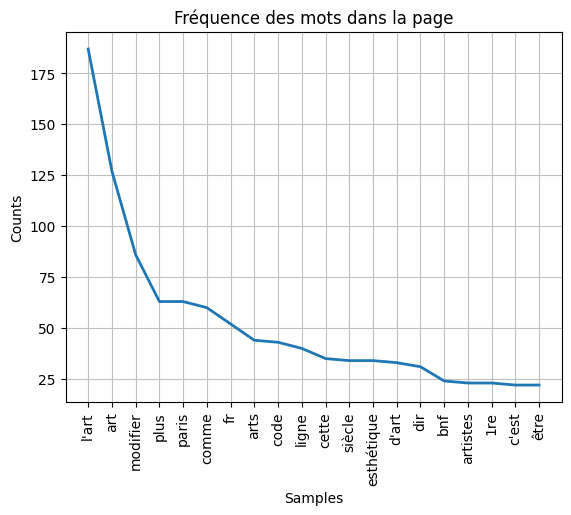

<FreqDist with 3733 samples and 8095 outcomes>


In [41]:
from nltk.corpus import stopwords
import string

# après un premier affichage des mots les plus trouvés j'en ai rajoutés d'autre
stopword = stopwords.words('french') + ['les', 'a', 'il', '+', ',', '<', '>', "'", "↑", "'", "«", "»", "p.", "’", "éd", "isbn",]+list(string.punctuation)

tokens_propres = [mot for mot in tokens if mot not in stopword]

freq = nltk.FreqDist(tokens_propres)
#affiche les 20 mots les plus fréquent sur la page
freq.plot(20, title='Fréquence des mots dans la page')
print(freq)



# Word2Vec
j'ai essaie d'utiliser different méthode de visualisation : tsne pca et umap pour voir les difference, umpa ne fonctionne pas malheureusement

Visualisation avec des couleurs selon des groupes obtenu avec la methode des kmeans



In [76]:
from gensim.models import Word2Vec

#entraînement
model = Word2Vec([tokens_propres], vector_size = 100, 
                 window = 5, min_count = 5, workers = 4)

# on enregistre le modèle 
model.save("word2vecmodel")

# affichage de mot similaire récupérer 
syno = model.wv.most_similar("l'art", topn =20)
print(syno)
oppo = model.wv.most_similar(negative=["l'art"], topn=20)  # Obtenir les mots opposés
print(oppo)

wordvec = model.wv.vectors

[('art', 0.9785946607589722), ('fr', 0.9736273288726807), ('modifier', 0.9675307273864746), ('ligne', 0.9672449827194214), ('paris', 0.9661641716957092), ('cette', 0.9653077125549316), ('comme', 0.9607411623001099), ('dir', 0.9589544534683228), ('esthétique', 0.9562346339225769), ('code', 0.9561651945114136), ('lire', 0.9524521231651306), ('plus', 0.9520782828330994), ('bnf', 0.9506983757019043), ('arts', 0.9505813717842102), ('1re', 0.9487009048461914), ('coll', 0.9476537704467773), ('b', 0.9476410746574402), ('2001', 0.9453939199447632), ('œuvres', 0.9447945952415466), ('théorie', 0.943447470664978)]
[('pratique', -0.6230177879333496), ('périodes', -0.6475850939750671), ('îles', -0.6601768136024475), ('africain', -0.6613215208053589), ('renaissance', -0.6761873364448547), ('précise', -0.6768745183944702), ('conçue', -0.6770760416984558), ('différentes', -0.6781113147735596), ('premiers', -0.6937828660011292), ('sujet', -0.6962675452232361), ('articles', -0.7008079886436462), ('ancien

## Méthode de transformation
Réduction de la dimension pour avoir une visualisation 3D
utilisez en une puis passez a la visualization

## PCA

In [78]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)  
word_vectors_2D = pca.fit_transform(model.wv.vectors)

## UMPA

In [91]:
import umap

reduce = umap.UMAP(n_components=2)  
word_vectors_2D = reduce.fit_transform(model.wv.vectors)

## TSNE

In [74]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
word_vectors_2D = tsne.fit_transform(wordvec)

## Kmeans
Essaie d'utilisation de la méthode des kmeans pour afficher des regroupement de mots via differentes couleurs

In [93]:
from sklearn.cluster import KMeans

# essaie de changer le nombre de cluster "n_clusters" pour avoir un meilleur visuel
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(word_vectors_2D)
cluster_labels = kmeans.labels_.astype(int)
# on peux changer ici les couleurs et en rajouter celon le nombre de groupe fait
colors = ['blue', 'red', 'green']  


## Visualisation

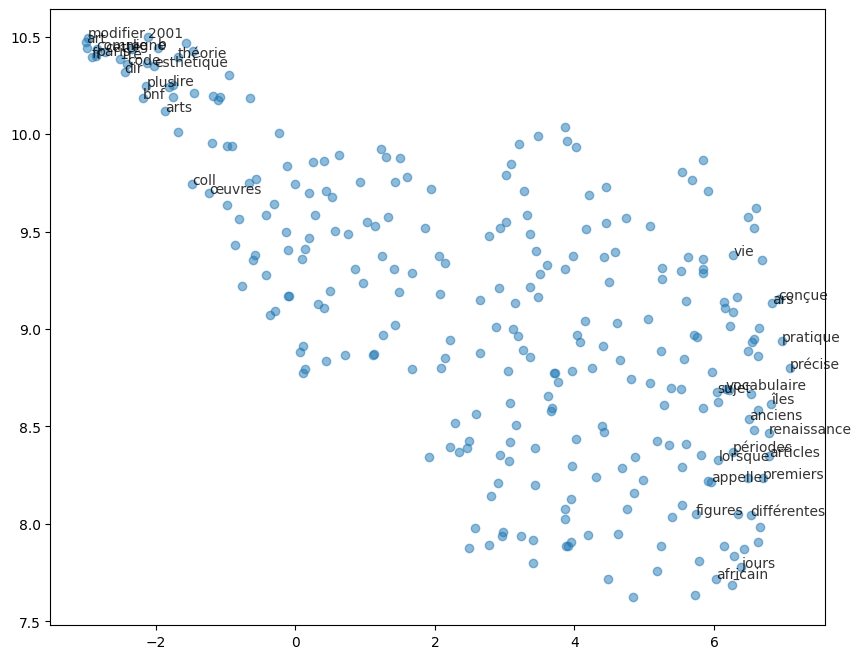

In [97]:
import pandas as pd
import matplotlib.pyplot as plot

vocab = list(model.wv.index_to_key)
df = pd.DataFrame(word_vectors_2D, index = vocab, columns=['x', 'y'])

plot.figure(figsize=(10, 8))
plot.scatter(df['x'],df['y'], alpha=0.5)

#on va afficher sur le graphe les noms des 20 points les plus "proche"
# ainsi que les 20 points les plus "loin" du mot "l'art"
for word,value in syno + oppo:
    plot.annotate(word, (df.loc[word, 'x'], df.loc[word, 'y']), alpha=0.8, fontsize=10)

plot.show()

# Conclusion
Celon la méthode de transformation utilisé on obtiens de total differente visualisation

Nous retrouvons assez facilement sur chacun des visualisation les deux groupes de mots "loin" et "proche" tout le temps a l'opposé 

Mais nous somme sur une représentation 2D d'une 100 de vecteurs donc cela reste encore complexe d'interpréter 